
# MSIT 3103 · Assignment 3 Hotstart Notebook  
**Prompt Engineering Lab with Local Models (Ollama + LLaMA 3.2 1B)**

> Use this notebook to run structured prompt‑engineering experiments on a **local** small model (e.g., `llama3.2:1b` via Ollama).  
> You will implement Steps 1–4 (Basic → Structured → Few‑shot → CoT), collect outputs, and analyze results.



## 0) Local Environment Check

This notebook assumes you have **[Ollama](https://ollama.com/)** installed locally and the `llama3.2:1b` model available.

- Install Ollama: follow your OS‑specific steps from the website.  
- Pull the model (in a terminal):  
```bash
ollama pull llama3.2:1b
```
- Verify command works (from terminal): `ollama run llama3.2:1b "hello"`

> If you're executing this notebook on a machine without Ollama, use these cells as **documentation** and run the actual commands on your local machine. You can paste results back here for analysis.


In [4]:

import json, os, subprocess, time, uuid, textwrap
from dataclasses import dataclass, asdict
from typing import List, Dict

RESULTS_DIR = "a3_outputs"
os.makedirs(RESULTS_DIR, exist_ok=True)

def ollama_run(model: str, prompt: str, options: Dict=None, timeout: int = 120) -> str:
    """Run a prompt through a local Ollama model via subprocess and return the text.

    Requires Ollama to be installed and available on PATH.

    """
    cmd = ["ollama", "run", model]
    if options:
        # Ollama CLI supports options via the JSON API; here we keep CLI simple.
        # For advanced options, consider using `ollama generate -m model -p prompt --options '{...}'` pattern.
        pass
    proc = subprocess.run(cmd, input=prompt.encode("utf-8"), stdout=subprocess.PIPE, stderr=subprocess.PIPE, timeout=timeout)
    if proc.returncode != 0:
        raise RuntimeError(f"Ollama error: {proc.stderr.decode('utf-8', errors='ignore')}")
    return proc.stdout.decode("utf-8", errors="ignore")

@dataclass
class Trial:
    step: str                 # basic / structured / fewshot / cot
    task_id: str              # arbitrary id of the task/question
    prompt: str
    response: str
    meta: Dict

def save_trials(trials: List[Trial], path: str):
    with open(path, "w", encoding="utf-8") as f:
        json.dump([asdict(t) for t in trials], f, ensure_ascii=False, indent=2)
    print(f"Saved {len(trials)} trials to {path}")



## 1) Context Document & Tasks

Create/Load a short **context document** (few paragraphs) and a small set of **tasks** to query the model with.  
You may replace the placeholder context and tasks below with your own domain (e.g., finance, health, policy, product requirements).

> Keep **5–10 tasks** so runs complete quickly.


In [5]:

CONTEXT = """
United FC is building "GoalSense", a football performance and fan engagement app. Users can track live match stats, follow their favorite players, set team goals, and receive personalized insights.
New roadmap items include: AI-driven match predictions, injury-risk analysis, fantasy league integration, and advanced training automation for youth players.
The team monitors key football and business metrics such as possession percentage, pass accuracy, shots on target, ticket sales, fan engagement, and player transfer value.
""".strip()

TASKS = [
    {"id": "t1", "question": "Summarize the key features of the GoalSense app."},
    {"id": "t2", "question": "List five KPIs United FC should track and explain why each matters."},
    {"id": "t3", "question": "Propose two experiments to increase fan engagement and stadium attendance."},
    {"id": "t4", "question": "Draft a short FAQ: 'How does goal-tracking work on GoalSense?'."},
    {"id": "t5", "question": "Explain how ticket sales and fan lifetime value (LTV) relate and why they are important for the club."},
    {"id": "t6", "question": "Recommend two football strategies suitable for a defensive-minded team."}
]

print(CONTEXT)
print("\nTasks:")
for t in TASKS:
    print("-", t["id"] + ":", t["question"])


United FC is building "GoalSense", a football performance and fan engagement app. Users can track live match stats, follow their favorite players, set team goals, and receive personalized insights.
New roadmap items include: AI-driven match predictions, injury-risk analysis, fantasy league integration, and advanced training automation for youth players.
The team monitors key football and business metrics such as possession percentage, pass accuracy, shots on target, ticket sales, fan engagement, and player transfer value.

Tasks:
- t1: Summarize the key features of the GoalSense app.
- t2: List five KPIs United FC should track and explain why each matters.
- t3: Propose two experiments to increase fan engagement and stadium attendance.
- t4: Draft a short FAQ: 'How does goal-tracking work on GoalSense?'.
- t5: Explain how ticket sales and fan lifetime value (LTV) relate and why they are important for the club.
- t6: Recommend two football strategies suitable for a defensive-minded team


## 2) Step 1 — Basic Prompting

- Ask direct, simple questions grounded in the context document.
- Log correctness, completeness, and clarity for later comparison.


In [6]:

MODEL = "llama3.2:1b"

basic_trials = []
for task in TASKS:
    prompt = f"""
You are a helpful assistant.

Context:
{CONTEXT}

Question:
{task['question']}
""".strip()
    try:
        resp = ollama_run(MODEL, prompt)
    except Exception as e:
        resp = f"[ERROR running model locally] {e}"
    basic_trials.append(Trial(step="basic", task_id=task["id"], prompt=prompt, response=resp, meta={}))

save_trials(basic_trials, os.path.join(RESULTS_DIR, "step1_basic.json"))


Saved 6 trials to a3_outputs/step1_basic.json



## 3) Step 2 — Structured Output Prompts

- Instruct the model to output **strict JSON** or bullet lists/tables.
- Compare accuracy & reliability with Step 1.


In [7]:

structured_trials = []
for task in TASKS:
    prompt = f"""
You are a helpful assistant. Return the answer in **strict JSON** with keys:
- "answer": string
- "supporting_facts": list of short strings derived from the context
- "confidence": number in [0,1]

Context:
{CONTEXT}

Question:
{task['question']}

If something is unknowable from the context, set "confidence": 0 and use an empty "supporting_facts".
""".strip()
    try:
        resp = ollama_run(MODEL, prompt)
    except Exception as e:
        resp = f"[ERROR running model locally] {e}"
    structured_trials.append(Trial(step="structured", task_id=task["id"], prompt=prompt, response=resp, meta={"format":"json"}))

save_trials(structured_trials, os.path.join(RESULTS_DIR, "step2_structured.json"))


Saved 6 trials to a3_outputs/step2_structured.json



## 4) Step 3 — Few‑shot Prompting

- Provide **1–3 short examples** to steer the style & content.
- Compare results with Steps 1–2.


In [8]:

FEW_SHOT_EXAMPLES = [
    {
        "q": "What does possession percentage mean?",
        "a": "It measures the share of time a team controls the ball during a match, reflecting dominance and ability to dictate play."
    },
    {
        "q": "Name two roadmap features in GoalSense and briefly describe them.",
        "a": "- AI-driven match predictions: personalized forecasts of match outcomes based on team form and player stats.\n- Fantasy league integration: allows fans to build virtual squads and compete using real-world player performance."
    },
    {
        "q": "Suggest one experiment to increase stadium attendance.",
        "a": "Introduce discounted family ticket bundles and loyalty perks for repeat attendees to boost turnout on match days."
    }
]


def render_fewshot_block(examples):
    parts = ["You are a helpful assistant. Here are some QA examples:"]
    for ex in examples:
        parts.append(f"Q: {ex['q']}\nA: {ex['a']}")
    return "\n\n".join(parts)

fewshot_prefix = render_fewshot_block(FEW_SHOT_EXAMPLES)

fewshot_trials = []
for task in TASKS:
    prompt = f"""
{fewshot_prefix}

Now answer the new question using the context below.

Context:
{CONTEXT}

Question:
{task['question']}
""".strip()
    try:
        resp = ollama_run(MODEL, prompt)
    except Exception as e:
        resp = f"[ERROR running model locally] {e}"
    fewshot_trials.append(Trial(step="fewshot", task_id=task["id"], prompt=prompt, response=resp, meta={"k": len(FEW_SHOT_EXAMPLES)}))

save_trials(fewshot_trials, os.path.join(RESULTS_DIR, "step3_fewshot.json"))


Saved 6 trials to a3_outputs/step3_fewshot.json



## 5) Step 4 — Chain‑of‑Thought (CoT) Prompting

- Encourage explicit reasoning (e.g., _"Let's think step by step."_).  
- Compare reasoning quality, correctness, and verbosity with prior steps.

> **Note:** When writing your report, avoid pasting raw CoT traces if disallowed by an evaluation policy. Summarize the reasoning instead.


In [9]:
cot_trials = []
for task in TASKS:
    prompt = f"""
You are a helpful assistant. Think step by step and show your reasoning (3–6 short steps). Use ONLY the CONTEXT below; do not invent facts. After reasoning, provide a one-line final answer prefixed with "Final Answer:". If the answer is unknowable from the context, state "Unknown from context".

Context:
{CONTEXT}

Question:
{task['question']}
""".strip()
    try:
        resp = ollama_run(MODEL, prompt)
    except Exception as e:
        resp = f"[ERROR running model locally] {e}"
    cot_trials.append(Trial(step="cot", task_id=task["id"], prompt=prompt, response=resp, meta={"cot": True}))

save_trials(cot_trials, os.path.join(RESULTS_DIR, "step4_cot.json"))


Saved 6 trials to a3_outputs/step4_cot.json



## 6) Scoring Scaffold (Manual or Programmatic)

Rate each response on:
- **Correctness** (0–5), **Completeness** (0–5), **Clarity** (0–5).  
Optionally mark factual errors.

Fill the table below manually (or write a simple heuristic scorer).


In [11]:

!pip install pandas

import json, glob, pandas as pd

def load_trials(pattern):
    rows = []
    for path in sorted(glob.glob(pattern)):
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        for item in data:
            rows.append({
                "file": os.path.basename(path),
                "step": item["step"],
                "task_id": item["task_id"],
                "prompt": item["prompt"],
                "response": item["response"],
            })
    return pd.DataFrame(rows)

df = load_trials(os.path.join(RESULTS_DIR, "step*.json"))
df.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 9.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 13.2 MB/s eta 0:00:00a 0:00:01


file   step task_id  \
0  step1_basic.json  basic      t1   
1  step1_basic.json  basic      t2   
2  step1_basic.json  basic      t3   
3  step1_basic.json  basic      t4   
4  step1_basic.json  basic      t5   

                                              prompt  \
0  You are a helpful assistant.\n\nContext:\nUnit...   
1  You are a helpful assistant.\n\nContext:\nUnit...   
2  You are a helpful assistant.\n\nContext:\nUnit...   
3  You are a helpful assistant.\n\nContext:\nUnit...   
4  You are a helpful assistant.\n\nContext:\nUnit...   

                                            response  
0  Based on the provided information, here are th...  
1  As a helpful assistant, I'd be happy to provid...  
2  As a helpful assistant, I'd be happy to propos...  
3  Here's a draft of the FAQ section for "GoalSen...  
4  As a helpful assistant, I'd be happy to explai...

In [12]:

# Add scoring columns and export a CSV for manual rating
df_scores = df.copy()
for col in ["correctness_0_5", "completeness_0_5", "clarity_0_5", "notes"]:
    if col not in df_scores.columns:
        df_scores[col] = ""

out_csv = os.path.join(RESULTS_DIR, "ratings_template.csv")
df_scores.to_csv(out_csv, index=False)
out_csv


'a3_outputs/ratings_template.csv'


## 7) Aggregate & Compare

After you fill in `ratings_template.csv`, re‑import and compute per‑step averages.


In [14]:

import pandas as pd, numpy as np

ratings_path = os.path.join(RESULTS_DIR, "ratings_template_1.csv")
# Try utf-8-sig first, fallback to latin1 if error persists
try:
    ratings = pd.read_csv(ratings_path, encoding="utf-8-sig")
except UnicodeDecodeError:
    ratings = pd.read_csv(ratings_path, encoding="latin1")

def to_num(x):
    try:
        return float(x)
    except:
        return np.nan

ratings["correctness_0_5"] = ratings["correctness_0_5"].apply(to_num)
ratings["completeness_0_5"] = ratings["completeness_0_5"].apply(to_num)
ratings["clarity_0_5"] = ratings["clarity_0_5"].apply(to_num)

summary = ratings.groupby("step")[["correctness_0_5","completeness_0_5","clarity_0_5"]].mean().round(2)
summary


correctness_0_5  completeness_0_5  clarity_0_5
step                                                      
basic                  4.33              4.67         4.33
cot                    4.00              4.00         4.00
fewshot                4.33              5.00         4.33
structured             3.50              3.33         4.00


## 8) Visualization

Plot average scores by step (Basic vs Structured vs Few‑shot vs CoT).


Note: you may need to restart the kernel to use updated packages.


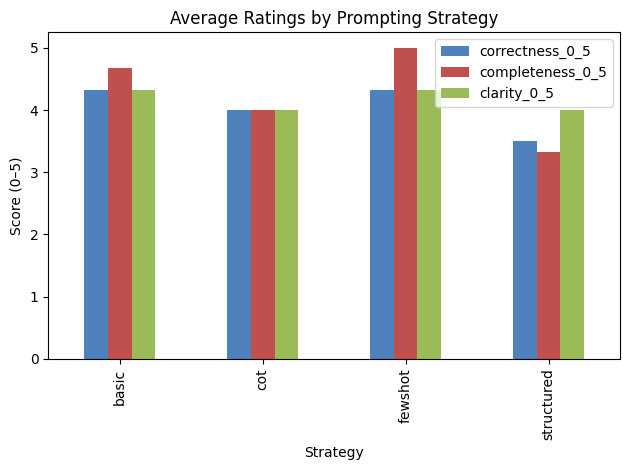

In [17]:

%pip install matplotlib

import matplotlib.pyplot as plt

custom_colors = ["#4F81BD", "#C0504D", "#9BBB59", "#8064A2"]  # Example: blue, red, green, purple

summary.plot(kind="bar", color=custom_colors)
plt.title("Average Ratings by Prompting Strategy")
plt.ylabel("Score (0–5)")
plt.xlabel("Strategy")
plt.tight_layout()
plt.show()